In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import AMM_sim_functions as sim
import fast_AMM_sim_functions as fsim

In [2]:
# Market Parameters

T = 1 # Time horizon
N = 1440 # Number of periods
dt = T/N # Time increment
buy = 2500.*dt # Constant trade size for systematic buyers
sell = -2500.*dt # Constant trade size for systematic sellers
eta0 = 0.005 # CEX proportional cost
eta1 = 0.0025 # CPMM proportional cost
X = 30000000 # Initial CPMM Dollar Reserves
Y = 10000 # Initial CPMM Asset Reserves
S = X/Y # Initial CEX Price
sigma = 0.05 # Standard deviation of CEX price shock
mu = 0  # Mean of CEX price shock
M = 10000 # Total number of sims
time = np.array([i * dt for i in range(N+1)]) # Time grid

In [3]:
S0 = sim.CEX_Price(S, mu, sigma, dt, N, M) # Generate price series

filtr_bfs , filtr_sfs =  sim.generate_trade_filters(N, M) # Generate buyer-first/seller-first trade filter

In [4]:
# Set of AMM Fee values to test
eta1_vals = np.array([i*0.000025 for i in range(0,401)]) # Set of possible eta values
eta1_vals

array([0.000e+00, 2.500e-05, 5.000e-05, 7.500e-05, 1.000e-04, 1.250e-04,
       1.500e-04, 1.750e-04, 2.000e-04, 2.250e-04, 2.500e-04, 2.750e-04,
       3.000e-04, 3.250e-04, 3.500e-04, 3.750e-04, 4.000e-04, 4.250e-04,
       4.500e-04, 4.750e-04, 5.000e-04, 5.250e-04, 5.500e-04, 5.750e-04,
       6.000e-04, 6.250e-04, 6.500e-04, 6.750e-04, 7.000e-04, 7.250e-04,
       7.500e-04, 7.750e-04, 8.000e-04, 8.250e-04, 8.500e-04, 8.750e-04,
       9.000e-04, 9.250e-04, 9.500e-04, 9.750e-04, 1.000e-03, 1.025e-03,
       1.050e-03, 1.075e-03, 1.100e-03, 1.125e-03, 1.150e-03, 1.175e-03,
       1.200e-03, 1.225e-03, 1.250e-03, 1.275e-03, 1.300e-03, 1.325e-03,
       1.350e-03, 1.375e-03, 1.400e-03, 1.425e-03, 1.450e-03, 1.475e-03,
       1.500e-03, 1.525e-03, 1.550e-03, 1.575e-03, 1.600e-03, 1.625e-03,
       1.650e-03, 1.675e-03, 1.700e-03, 1.725e-03, 1.750e-03, 1.775e-03,
       1.800e-03, 1.825e-03, 1.850e-03, 1.875e-03, 1.900e-03, 1.925e-03,
       1.950e-03, 1.975e-03, 2.000e-03, 2.025e-03, 

In [5]:
# Set of sigma values for simulation
sigma_vals = np.array([i*0.002 for i in range(1,41)]) # Set of possible sigma values
sigma_vals

array([0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016, 0.018,
       0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034, 0.036,
       0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052, 0.054,
       0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 , 0.072,
       0.074, 0.076, 0.078, 0.08 ])

In [6]:
%%time

# Collect data
all_outputs = {}  # Dictionary to store outputs keyed by sigma

for i in range(len(sigma_vals)):
    sigma_value = sigma_vals[i]
    print("Sigma Value:", sigma_value)
    
    # Set the sigma for this iteration and simulate the CEX price series.
    sigma = sigma_value
    S0 = sim.CEX_Price(S, mu, sigma, dt, N, M)
    
    # Run the parallel simulation for each eta1 value.
    output_vals = Parallel(n_jobs=12)(
        delayed(fsim.fast_simulation_summary)(
            M, N, T, dt, buy, sell, eta0, eta1_vals[j], S0, X, Y, filtr_bfs, filtr_sfs
        )
        for j in tqdm(range(len(eta1_vals)))
    )
    
    # Store the output in the dictionary.
    all_outputs[sigma_value] = np.array(output_vals)


Sigma Value: 0.002


100%|█████████████████████████████████████████| 401/401 [00:27<00:00, 14.76it/s]


Sigma Value: 0.004


100%|█████████████████████████████████████████| 401/401 [00:26<00:00, 15.24it/s]


Sigma Value: 0.006


100%|█████████████████████████████████████████| 401/401 [00:28<00:00, 14.16it/s]


Sigma Value: 0.008


100%|█████████████████████████████████████████| 401/401 [00:27<00:00, 14.55it/s]


Sigma Value: 0.01


100%|█████████████████████████████████████████| 401/401 [00:18<00:00, 21.12it/s]


Sigma Value: 0.012


100%|█████████████████████████████████████████| 401/401 [00:18<00:00, 21.89it/s]


Sigma Value: 0.014


100%|█████████████████████████████████████████| 401/401 [00:24<00:00, 16.38it/s]


Sigma Value: 0.016


100%|█████████████████████████████████████████| 401/401 [00:18<00:00, 21.31it/s]


Sigma Value: 0.018000000000000002


100%|█████████████████████████████████████████| 401/401 [00:18<00:00, 22.09it/s]


Sigma Value: 0.02


100%|█████████████████████████████████████████| 401/401 [00:25<00:00, 15.73it/s]


Sigma Value: 0.022


100%|█████████████████████████████████████████| 401/401 [00:23<00:00, 17.17it/s]


Sigma Value: 0.024


100%|█████████████████████████████████████████| 401/401 [00:18<00:00, 21.83it/s]


Sigma Value: 0.026000000000000002


100%|█████████████████████████████████████████| 401/401 [00:18<00:00, 21.18it/s]


Sigma Value: 0.028


100%|█████████████████████████████████████████| 401/401 [00:18<00:00, 21.50it/s]


Sigma Value: 0.03


100%|█████████████████████████████████████████| 401/401 [00:23<00:00, 16.98it/s]


Sigma Value: 0.032


100%|█████████████████████████████████████████| 401/401 [00:19<00:00, 20.58it/s]


Sigma Value: 0.034


100%|█████████████████████████████████████████| 401/401 [00:18<00:00, 21.17it/s]


Sigma Value: 0.036000000000000004


100%|█████████████████████████████████████████| 401/401 [00:19<00:00, 20.91it/s]


Sigma Value: 0.038


100%|█████████████████████████████████████████| 401/401 [00:21<00:00, 18.37it/s]


Sigma Value: 0.04


100%|█████████████████████████████████████████| 401/401 [00:19<00:00, 20.30it/s]


Sigma Value: 0.042


100%|█████████████████████████████████████████| 401/401 [00:19<00:00, 20.48it/s]


Sigma Value: 0.044


100%|█████████████████████████████████████████| 401/401 [00:27<00:00, 14.47it/s]


Sigma Value: 0.046


100%|█████████████████████████████████████████| 401/401 [00:18<00:00, 21.27it/s]


Sigma Value: 0.048


100%|█████████████████████████████████████████| 401/401 [00:25<00:00, 15.94it/s]


Sigma Value: 0.05


100%|█████████████████████████████████████████| 401/401 [00:31<00:00, 12.58it/s]


Sigma Value: 0.052000000000000005


100%|█████████████████████████████████████████| 401/401 [00:18<00:00, 22.08it/s]


Sigma Value: 0.054


100%|█████████████████████████████████████████| 401/401 [00:26<00:00, 15.09it/s]


Sigma Value: 0.056


100%|█████████████████████████████████████████| 401/401 [00:19<00:00, 20.87it/s]


Sigma Value: 0.058


100%|█████████████████████████████████████████| 401/401 [00:19<00:00, 20.66it/s]


Sigma Value: 0.06


100%|█████████████████████████████████████████| 401/401 [00:19<00:00, 20.67it/s]


Sigma Value: 0.062


100%|█████████████████████████████████████████| 401/401 [00:19<00:00, 20.71it/s]


Sigma Value: 0.064


100%|█████████████████████████████████████████| 401/401 [00:21<00:00, 18.45it/s]


Sigma Value: 0.066


100%|█████████████████████████████████████████| 401/401 [00:25<00:00, 15.44it/s]


Sigma Value: 0.068


100%|█████████████████████████████████████████| 401/401 [00:20<00:00, 20.02it/s]


Sigma Value: 0.07


100%|█████████████████████████████████████████| 401/401 [00:19<00:00, 20.06it/s]


Sigma Value: 0.07200000000000001


100%|█████████████████████████████████████████| 401/401 [00:19<00:00, 20.55it/s]


Sigma Value: 0.074


100%|█████████████████████████████████████████| 401/401 [00:19<00:00, 20.21it/s]


Sigma Value: 0.076


100%|█████████████████████████████████████████| 401/401 [00:24<00:00, 16.25it/s]


Sigma Value: 0.078


100%|█████████████████████████████████████████| 401/401 [00:19<00:00, 20.65it/s]


Sigma Value: 0.08


100%|█████████████████████████████████████████| 401/401 [00:30<00:00, 13.31it/s]


CPU times: user 39.5 s, sys: 8.57 s, total: 48 s
Wall time: 15min 55s


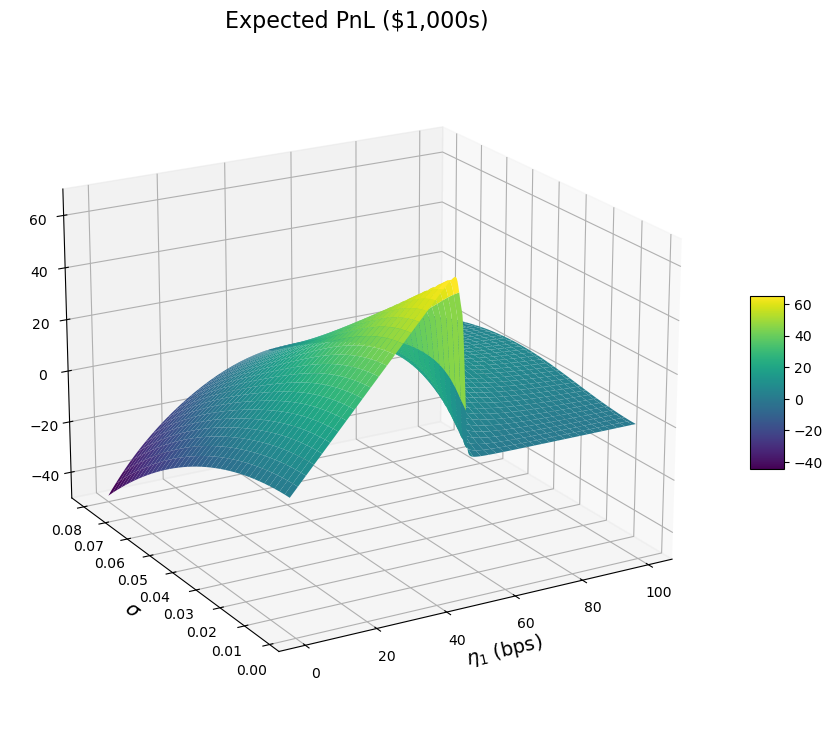

In [25]:
# Create a 2D array to store the objective value (Expected PnL) for each (sigma, eta1) pair.
obj = np.empty((len(sigma_vals), len(eta1_vals)))

for i, sigma in enumerate(sigma_vals):
    outputs = all_outputs[sigma]  # List of outputs for this sigma value
    for j in range(len(eta1_vals)):
        obj[i, j] = (outputs[j,0]+outputs[j,1]+outputs[j,2]+outputs[j,3]-outputs[j,4])/1000 # Compute objective

# Create a meshgrid for plotting.
ETA, SIGMA = np.meshgrid(eta1_vals, sigma_vals)

# Set figure size.
fig = plt.figure(figsize=(12, 9)) 
ax = fig.add_subplot(111, projection='3d')

# Set elevation and azimuth angles for plot.
ax.view_init(elev=20, azim=-120)

# Surface plot.
surface = ax.plot_surface(ETA * 10000, SIGMA, obj, cmap='viridis')

# Axes labels.
ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_zlabel('')
ax.set_title('Expected PnL ($1,000s)', fontsize=16)

# Add color bar.
fig.colorbar(surface, ax=ax, shrink=0.25, aspect=5)
plt.show()

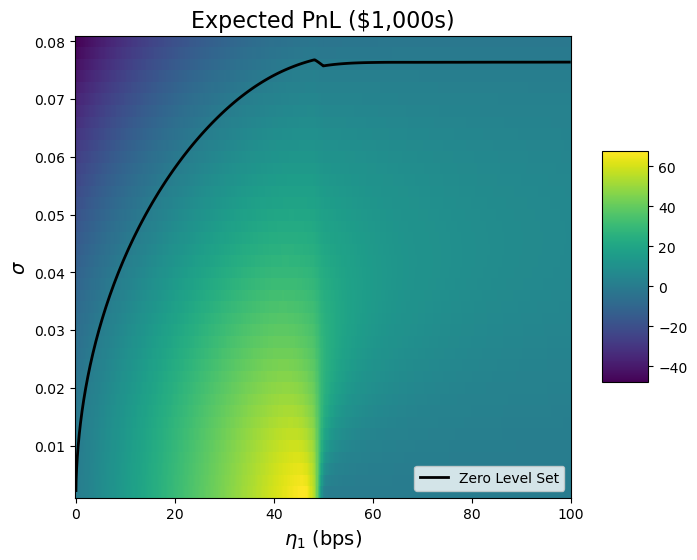

In [26]:
# Create a heatmap.
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.pcolormesh(ETA * 10000, SIGMA, obj, cmap='viridis', shading='auto')

# Overlay a black contour line at the zero level of the objective function.
contour = ax.contour(ETA * 10000, SIGMA, obj, levels=[0], colors='black', linewidths=2)

# Create a proxy for the contour line to use in the legend.
zls_line = Line2D([0], [0], color='black', lw=2, label='Zero Level Set')

# Add the legend.
ax.legend(handles=[zls_line], loc='lower right')

# Axes labels.
ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
ax.set_ylabel(r'$\sigma$', fontsize=14)
ax.set_title('Expected PnL ($1,000s)', fontsize=16)

# Add a colorbar.
cbar = fig.colorbar(heatmap, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('', fontsize=14)

plt.show()


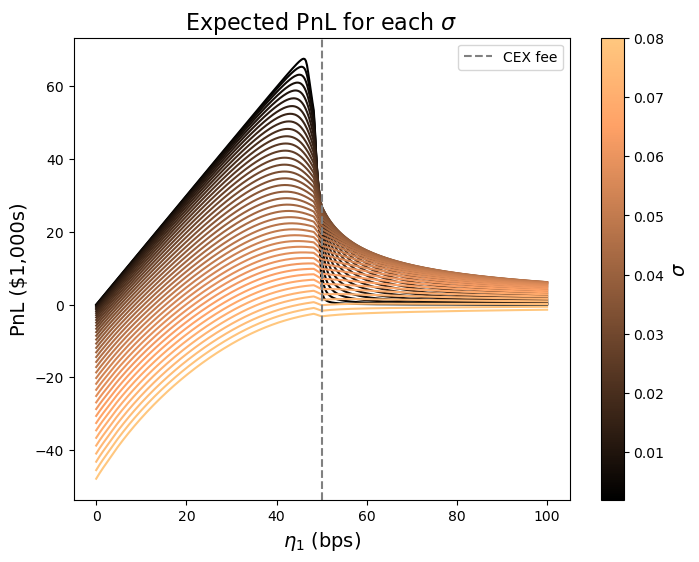

In [27]:
# Create a color gradient in the values of sigma.
norm_sigma = mpl.colors.Normalize(vmin=np.min(sigma_vals), vmax=np.max(sigma_vals))
cmap = plt.get_cmap("copper")

# Create the figure and axis.
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the objective (Expected PnL) as a function of eta1 for each sigma value.
for i, sigma in enumerate(sigma_vals):
    # Get a color corresponding to the current sigma and plot the objective.
    color = cmap(norm_sigma(sigma))
    ax.plot(eta1_vals * 10000, obj[i, :], color=color, label='')

# Add vertical line to indicate CEX fee level
plt.axvline(x=eta0 * 10000, color="grey", linestyle="--", label="CEX fee")

# Label the axes.
ax.set_xlabel(r'$\eta_1$ (bps)', fontsize=14)
ax.set_ylabel('PnL ($1,000s)', fontsize=14)
ax.set_title(r'Expected PnL for each $\sigma$', fontsize=16)
ax.legend(loc='upper right')

# Add a colorbar corresponding to the value of sigma.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_sigma)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label(r'$\sigma$', fontsize=14)

plt.show()
